# Analysis of decentralised iterative auction heuristics

In [1]:
from __future__ import annotations

import os
import sys
sys.path.append(os.path.join(os.getcwd(), ".."))

import json
from typing import List

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from src.extra.io import save_plot, ImageFormat

matplotlib.rcParams['font.family'] = "monospace"
%matplotlib inline

## Heuristic grid search

In [2]:
results_filename = '../data/dia_heuristics/dia_heuristic_grid_search_paper_r_t30_s6_dt07-22_12-17-27.json'

with open(results_filename) as file:
    results_data = json.load(file)

In [3]:
heuristic_results = {}
for model_results in results_data:
    for heuristic, heuristic_result in model_results.items():
        if heuristic == 'model':
            continue
        if heuristic in heuristic_results:
            heuristic_results[heuristic].append(heuristic_result)
        else:
            heuristic_results[heuristic] = [heuristic_result]
            
print(f'Number of heuristics: {len(heuristic_results)}')

Number of heuristics: 25


In [4]:
heuristic_avg_results = []
for heuristic, results in heuristic_results.items():
    heuristic_avg_results.append([
        heuristic,
        results[0]['price change'],
        results[0]['initial price'],
        [r['social welfare'] for r in results],
        [r['social welfare percent'] for r in results],
        [r['percentage tasks allocated'] for r in results],
        [r['total revenue'] for r in results],
        [r['rounds'] for r in results],
        [r['solve time'] for r in results],
        [task_price for r in results for task_price in r['task prices'].values()],
        np.mean([r['social welfare'] for r in results]),
        np.mean([r['total revenue'] for r in results]),
        np.mean([r['rounds'] for r in results]),
        np.mean([task_rounds for r in results for task_rounds in r['task rounds'].values()])
    ])
    
heuristic_df = pd.DataFrame(heuristic_avg_results, columns=[
    'name', 'price change', 'initial price', 'social welfare', 'social welfare percent', 
    'percentage tasks allocated', 'revenue', 'rounds', 'solve time', 'task prices', 
    'avg social welfare', 'avg revenue', 'avg rounds', 'avg task rounds',
])
heuristic_df = heuristic_df.sort_values(by=['price change', 'initial price'])

### General results

Text(0.5, 1.0, 'Percentage Tasks Allocated')

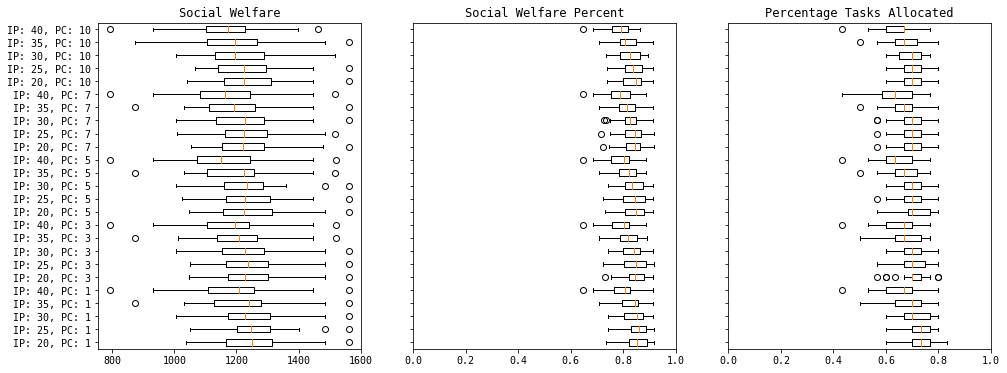

In [5]:
system_fig, (ax_sw, ax_swp, ax_pta) = plt.subplots(1, 3, figsize=(16, 6))
ax_sw.boxplot(heuristic_df['social welfare'], vert=False)
ax_sw.set_yticklabels(heuristic_df['name'])
ax_sw.set_title('Social Welfare')

ax_swp.boxplot(heuristic_df['social welfare percent'], vert=False)
plt.setp(ax_swp.get_yticklabels(), visible=False)
ax_swp.set_xticks(np.arange(0, 1.2, 0.2))
ax_swp.set_title('Social Welfare Percent')

ax_pta.boxplot(heuristic_df['percentage tasks allocated'], vert=False)
plt.setp(ax_pta.get_yticklabels(), visible=False)
ax_pta.set_xticks(np.arange(0, 1.2, 0.2))
ax_pta.set_title('Percentage Tasks Allocated')

Text(0.5, 1.0, 'Solve time')

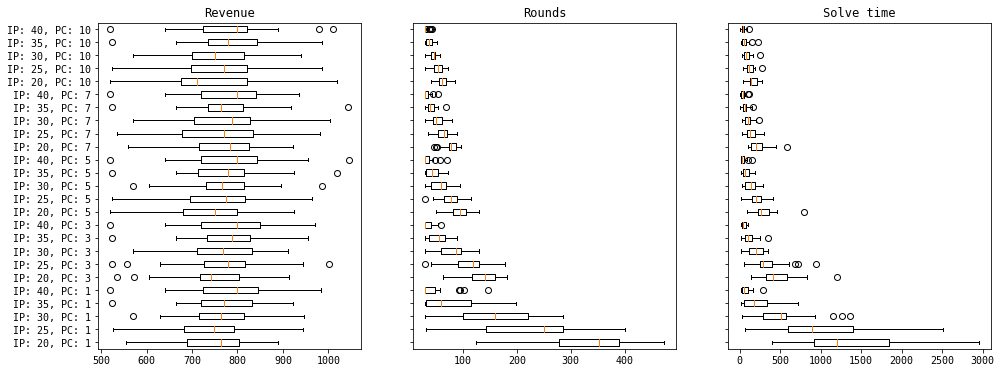

In [6]:
auction_fig, (ax_rev, ax_rounds, ax_solve_time) = plt.subplots(1, 3, figsize=(16, 6))
ax_rev.boxplot(heuristic_df['revenue'], vert=False)
ax_rev.set_yticklabels(heuristic_df['name'])
ax_rev.set_title('Revenue')

ax_rounds.boxplot(heuristic_df['rounds'], vert=False)
plt.setp(ax_rounds.get_yticklabels(), visible=False)
ax_rounds.set_title('Rounds')

ax_solve_time.boxplot(heuristic_df['solve time'], vert=False)
plt.setp(ax_solve_time.get_yticklabels(), visible=False)
ax_solve_time.set_title('Solve time')

### Grid search heatmap

In [7]:
def difference(results_1, results_2):
    sw, rev, rounds, solve_time, task_rounds = [], [], [], [], []
    for r1, r2 in zip(results_1, results_2):
        sw.append(r1['social welfare'] / r2['social welfare'])
        rev.append(r1['total revenue'] / r2['total revenue'])
        rounds.append(r1['rounds'] / r2['rounds'])
        solve_time.append(r1['solve time'] / r2['solve time'])
    return np.mean(sw), np.mean(rev), np.mean(rounds), np.mean(solve_time), sw, rev, rounds, solve_time

min_heuristic_results = heuristic_results['IP: 20, PC: 1']
heuristic_difference_results = [
    [heuristic, results[0]['price change'], results[0]['initial price'],
     *difference(results, min_heuristic_results)]
    for heuristic, results in heuristic_results.items()
]
heuristic_diff_df = pd.DataFrame(heuristic_difference_results, columns=[
    'name', 'price change', 'initial price', 
    'social welfare diff', 'revenue diff', 'rounds diff', 'solve time diff',
    'social welfare diff list', 'revenue diff list', 'rounds diff list', 'solve time diff list'
])

In [46]:
def custom_heatmap(ax, col, df, label_df, label_col, title='', print_heatmap=True,
                   initial_prices=['40', '35', '30', '25', '20'], price_changes=['1', '3', '5', '7', '10']):
    ax.set_yticks(np.arange(len(price_changes)))
    ax.set_yticklabels(list(reversed(price_changes)), fontsize=11)
    ax.set_ylabel('Bid Increment', fontsize=13)
    
    ax.set_xticks(np.arange(len(initial_prices)))
    ax.set_xticklabels(list(reversed(initial_prices)), fontsize=11)
    ax.set_xlabel('Reserve Price', fontsize=13)
    
    heatmap = ax.imshow(df.pivot(index='price change', columns='initial price', values=col).sort_index(axis=0, ascending=False))
    colour_bar = plt.colorbar(heatmap, shrink=0.82, ax=ax)
    # colour_bar.set_label('Normalised percentage difference', fontsize=13)
    
    if title:
        ax.set_title(title)
    
    for x, initial_price in enumerate(initial_prices):
        for y, price_change in enumerate(price_changes):
            label = label_df[label_df['name'] == f'IP: {initial_price}, PC: {price_change}'].get(label_col).values[0]
            ax.text(len(initial_prices) - 1 - x, len(price_changes) - 1 - y, 
                    round(label), color='white', ha='center', va='center', weight='bold', fontsize=12)
            
    if print_heatmap:
        print(f'\n\t{col}')
        print(df.pivot(index='price change', columns='initial price', 
                       values=col).sort_index(axis=0, ascending=False))
        print(f'\n\t{label_col}')
        print(label_df.pivot(index='price change', columns='initial price', 
                             values=label_col).sort_index(axis=0, ascending=False))
        print()

### Social Welfare


	social welfare diff
initial price        20        25        30        35        40
price change                                                   
10             0.985796  0.981687  0.968747  0.958330  0.923223
7              0.982451  0.981695  0.973124  0.953120  0.923699
5              0.990121  0.985925  0.981823  0.957004  0.925100
3              0.991906  0.990989  0.979704  0.962122  0.931088
1              1.000000  1.000343  0.987596  0.974881  0.938628

	avg social welfare
initial price           20           25           30           35           40
price change                                                                  
10             1236.148148  1230.407407  1215.037037  1203.370370  1159.259259
7              1231.925926  1231.407407  1220.851852  1196.185185  1161.185185
5              1242.037037  1236.925926  1231.518519  1201.111111  1162.481481
3              1243.777778  1242.888889  1229.259259  1207.666667  1170.000000
1              1254.148148  1254.37

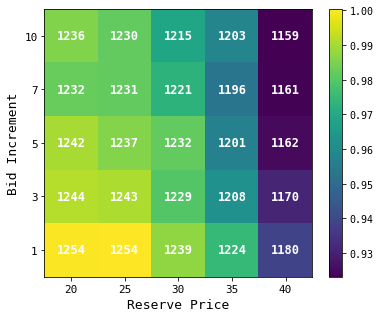

In [40]:
_, ax_gs_sw = plt.subplots(figsize=(6, 6))
custom_heatmap(ax_gs_sw, 'social welfare diff', heuristic_diff_df, heuristic_df, 'avg social welfare')
save_plot('social_welfare_grid', 'dia_heuristics')

### Revenue


	revenue diff
initial price        20        25        30        35        40
price change                                                   
10             1.002570  1.026294  1.023377  1.057717  1.058145
7              1.019661  1.016287  1.043814  1.043516  1.057678
5              1.000186  1.021306  1.030545  1.042410  1.065070
3              1.012231  1.034691  1.033605  1.050304  1.062287
1              1.000000  1.000482  1.031232  1.040805  1.070882

	avg revenue
initial price          20          25          30          35          40
price change                                                             
10             743.703704  762.037037  757.037037  783.518519  783.703704
7              756.148148  753.925926  773.296296  772.074074  782.740741
5              742.222222  758.333333  763.703704  772.407407  789.259259
3              751.000000  768.481481  766.111111  777.703704  787.222222
1              742.888889  742.851852  763.592593  770.851852  793.629630

Save

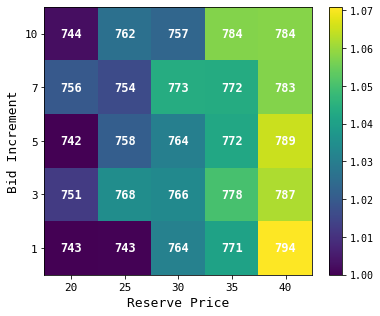

In [41]:
_, ax_gs_rev = plt.subplots(figsize=(6, 6))
custom_heatmap(ax_gs_rev, 'revenue diff', heuristic_diff_df, heuristic_df, 'avg revenue')
save_plot('revenue_grid', 'dia_heuristics')

### Rounds


	rounds diff
initial price        20        25        30        35        40
price change                                                   
10             0.199843  0.169570  0.141909  0.122977  0.107311
7              0.247549  0.200334  0.163892  0.133482  0.110022
5              0.293728  0.235356  0.177103  0.139074  0.115456
3              0.426578  0.329996  0.232850  0.167445  0.117333
1              1.000000  0.677873  0.461986  0.232657  0.143183

	avg rounds
initial price          20          25          30         35         40
price change                                                           
10              61.925926   53.555556   44.037037  37.703704  32.222222
7               77.777778   62.703704   51.740741  40.666667  33.037037
5               92.629630   75.851852   57.185185  43.703704  35.259259
3              136.296296  109.037037   76.888889  53.740741  36.111111
1              329.777778  230.370370  158.074074  78.814815  45.851852

Save file location: 

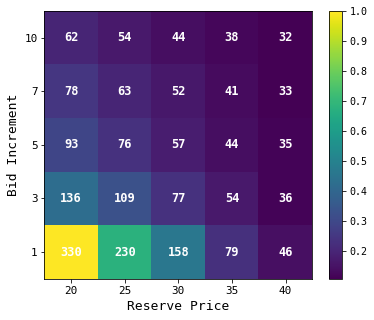

In [42]:
_, ax_gs_rounds = plt.subplots(figsize=(6, 6))
custom_heatmap(ax_gs_rounds, 'rounds diff', heuristic_diff_df, heuristic_df, 'avg rounds')
save_plot('rounds_grid', 'dia_heuristics')

### Average task rounds

In [12]:
heuristic_df.pivot(index='price change', columns='initial price', values='avg task rounds').sort_index(axis=0, ascending=False)

initial price,20,25,30,35,40
price change,,,,,
10,2.064198,1.785185,1.467901,1.256790,1.074074
7,2.592593,2.090123,1.724691,1.355556,1.101235
5,3.087654,2.528395,1.906173,1.456790,1.175309
3,4.543210,3.634568,2.562963,1.791358,1.203704
1,10.992593,7.679012,5.269136,2.627160,1.528395


### DIA Heuristics

Save file location: figs/dia_heuristics/eps/grid_search.eps
Save file location: figs/dia_heuristics/png/grid_search.png
Save file location: figs/dia_heuristics/pdf/grid_search.pdf


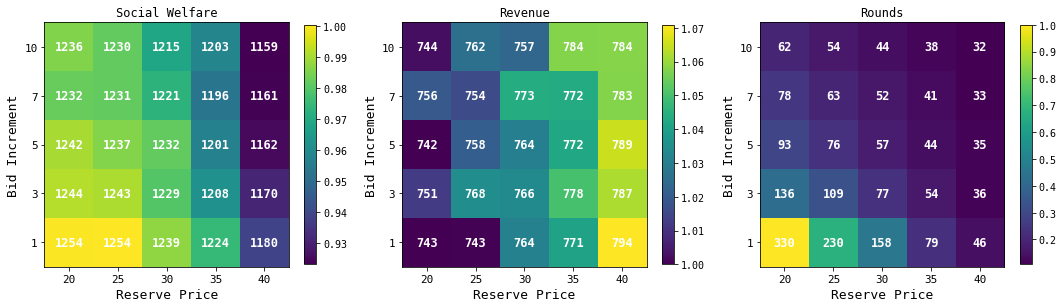

In [47]:
fig, (ax_social_welfare, ax_revenue, ax_rounds) = plt.subplots(1, 3, figsize=(15, 4.5))

custom_heatmap(ax_social_welfare, 'social welfare diff', heuristic_diff_df, heuristic_df, 'avg social welfare', 
               'Social Welfare', False)
custom_heatmap(ax_revenue, 'revenue diff', heuristic_diff_df, heuristic_df, 'avg revenue', 'Revenue', False)
custom_heatmap(ax_rounds, 'rounds diff', heuristic_diff_df, heuristic_df, 'avg rounds', 'Rounds', False)
plt.tight_layout()

save_plot('grid_search', 'dia_heuristics')

### Difference in social welfare, revenue and rounds

Text(0.5, 1.0, 'Difference in Rounds')

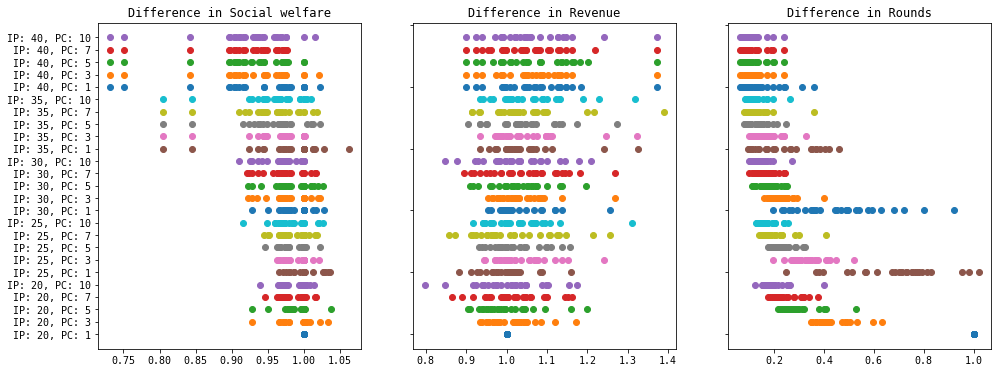

In [14]:
diff_fig, (ax_sw_diff, ax_rev_diff, ax_rounds_diff) = plt.subplots(1, 3, figsize=(16, 6))
for pos, (sw_diff, rev_diff, rounds_diff) in enumerate(heuristic_diff_df[['social welfare diff list', 
                                                                          'revenue diff list', 'rounds diff list']].values):
    ax_sw_diff.scatter(sw_diff, np.ones(len(sw_diff)) * pos)
    ax_rev_diff.scatter(rev_diff, np.ones(len(sw_diff)) * pos)
    ax_rounds_diff.scatter(rounds_diff, np.ones(len(sw_diff)) * pos)
    
ax_sw_diff.set_yticks(np.arange(len(heuristic_diff_df['name'])))
ax_sw_diff.set_yticklabels(heuristic_diff_df['name'], minor=False)
ax_sw_diff.set_title('Difference in Social welfare')

plt.setp(ax_rev_diff.get_yticklabels(), visible=False)
ax_rev_diff.set_title('Difference in Revenue')

plt.setp(ax_rounds_diff.get_yticklabels(), visible=False)
ax_rounds_diff.set_title('Difference in Rounds')

### Task Price

Text(0.5, 1.0, 'Task Price distribution')

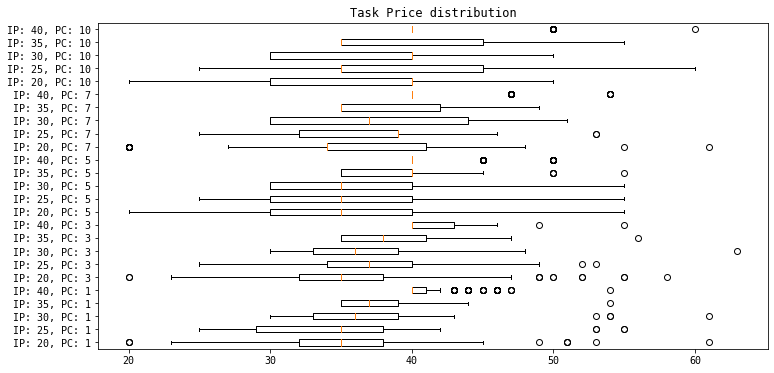

In [15]:
task_price_fig, ax_box_price = plt.subplots(figsize=(12, 6))
ax_box_price.boxplot(heuristic_df['task prices'], vert=False)
ax_box_price.set_yticklabels(heuristic_df['name'])
ax_box_price.set_title('Task Price distribution')

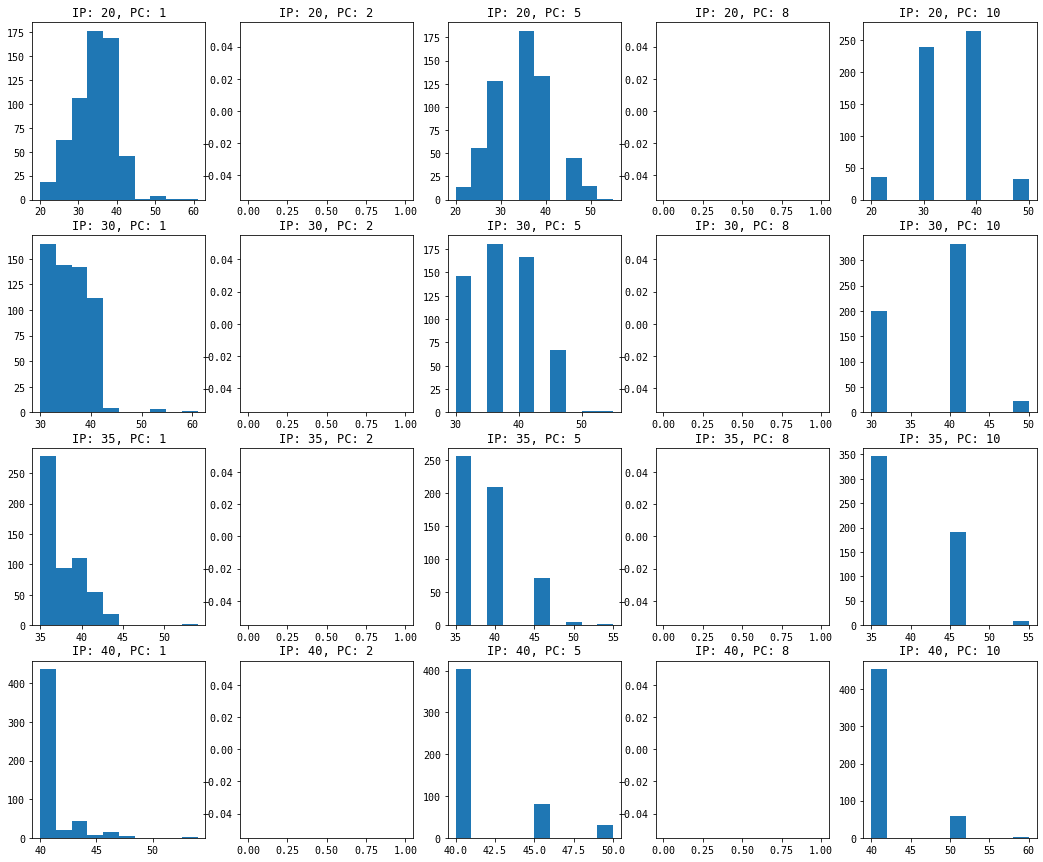

In [16]:
hist_fig, histograms = plt.subplots(4, 5, figsize=(18, 15))
for x, initial_price in enumerate(['20', '30', '35', '40']):
    for y, price_change in enumerate(['1', '2', '5', '8', '10']):
        histograms[x][y].hist(heuristic_df[heuristic_df['name'] == f'IP: {initial_price}, PC: {price_change}']['task prices'])
        histograms[x][y].set_title(f'IP: {initial_price}, PC: {price_change}')

## Non-uniform heuristics

In [17]:
results_filename = '../data/dia_heuristics/dia_non_uniform_heuristic_paper_r_t30_s6_dt07-14_15-06-16.json'

with open(results_filename) as file:
    results_data = json.load(file)

FileNotFoundError: [Errno 2] No such file or directory: '../data/dia_heuristics/dia_non_uniform_heuristic_paper_r_t30_s6_dt07-14_15-06-16.json'